# Q4: Empirical Analysis of ETFs

## Real Estate Select Sector SPDR Fund (XLRE) Analysis

This notebook analyzes the XLRE ETF by:
1. Finding the 30 largest holdings
2. Getting 6+ months of data
3. Computing daily returns
4. Computing covariance matrix
5. Performing PCA analysis
6. Performing SVD analysis


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [ ]:
import pandas as pd

holdings_df = pd.read_excel('holdings-daily-us-en-xlre.xlsx')

print("Successfully loaded official XLRE holdings data from SSGA")
print(f"Data shape: {holdings_df.shape}")
print(f"Columns: {list(holdings_df.columns)}")

print("\nFirst 10 rows of holdings data:")
print(holdings_df.head(10))


Successfully loaded official XLRE holdings data from SSGA
Data shape: (34, 8)
Columns: ['Name', 'Ticker', 'Identifier', 'SEDOL', 'Weight', 'Sector', 'Shares Held', 'Local Currency']

First 10 rows of holdings data:
                       Name Ticker Identifier    SEDOL    Weight Sector  \
0             WELLTOWER INC   WELL  95040Q104  BYVYHH4  9.671041      -   
1              PROLOGIS INC    PLD  74340W103  B44WZD7  8.714191      -   
2       AMERICAN TOWER CORP    AMT  03027X100  B7FBFL2  7.297255      -   
3               EQUINIX INC   EQIX  29444U700  BVLZX12  6.105700      -   
4  SIMON PROPERTY GROUP INC    SPG  828806109  2812452  4.889346      -   
5        REALTY INCOME CORP      O  756109104  2724193  4.518938      -   
6            PUBLIC STORAGE    PSA  74460D109  2852533  4.473921      -   
7  DIGITAL REALTY TRUST INC    DLR  253868103  B03GQS4  4.431353      -   
8        CBRE GROUP INC   A   CBRE  12504L109  B6WVMH3  4.277926      -   
9          CROWN CASTLE INC    CCI 

In [ ]:
def process_holdings_data(df):
    """
    Process the holdings DataFrame to extract top 30 holdings
    """
    df.columns = df.columns.str.strip().str.lower()
    ticker_col = None
    weight_col = None
    company_col = None
    
    for col in df.columns:
        if 'ticker' in col or 'symbol' in col:
            ticker_col = col
        elif 'weight' in col or 'percent' in col or '%' in col:
            weight_col = col
        elif 'name' in col or 'company' in col or 'security' in col:
            company_col = col
    
    print(f"Identified columns:")
    print(f"  Ticker: {ticker_col}")
    print(f"  Weight: {weight_col}")
    print(f"  Company: {company_col}")
    
    if ticker_col and weight_col:
        df_clean = df[[ticker_col, weight_col]].copy()
        if company_col:
            df_clean['company'] = df[company_col]
        else:
            df_clean['company'] = 'N/A'
        
        df_clean = df_clean.dropna()
        if df_clean[weight_col].dtype == 'object':
            df_clean[weight_col] = df_clean[weight_col].str.replace('%', '').astype(float)
        
        df_clean = df_clean.sort_values(weight_col, ascending=False)
        top_30 = df_clean.head(30)
        
        return top_30
    else:
        print("Could not identify required columns")
        return None

if 'holdings_df' in locals():
    top_30_holdings = process_holdings_data(holdings_df)
    
    if top_30_holdings is not None:
        print(f"\nTop 30 Holdings from Official SSGA Data:")
        print("=" * 70)
        print(f"{'Rank':<4} {'Ticker':<8} {'Weight (%)':<12} {'Company Name'}")
        print("-" * 70)
        
        for i, (_, row) in enumerate(top_30_holdings.iterrows(), 1):
            ticker = row.iloc[0]
            weight = row.iloc[1]
            company = row.get('company', 'N/A') if 'company' in row else 'N/A'
            print(f"{i:<4} {ticker:<8} {weight:<12.2f} {company}")
        
        major_holdings = top_30_holdings.iloc[:, 0].tolist()
        
        print(f"\nTotal holdings selected: {len(major_holdings)}")
        print(f"Ticker symbols: {', '.join(major_holdings[:10])}...")
        
    else:
        print("Failed to process holdings data. Please check the Excel file format.")
        print("Required columns: ticker/symbol and weight/percent")
else:
    print("Holdings data not available. Please ensure the Excel file is loaded correctly.")


Identified columns:
  Ticker: ticker
  Weight: weight
  Company: name

Top 30 Holdings from Official SSGA Data:
Rank Ticker   Weight (%)   Company Name
----------------------------------------------------------------------
1    WELL     9.67         WELLTOWER INC
2    PLD      8.71         PROLOGIS INC
3    AMT      7.30         AMERICAN TOWER CORP
4    EQIX     6.11         EQUINIX INC
5    SPG      4.89         SIMON PROPERTY GROUP INC
6    O        4.52         REALTY INCOME CORP
7    PSA      4.47         PUBLIC STORAGE
8    DLR      4.43         DIGITAL REALTY TRUST INC
9    CBRE     4.28         CBRE GROUP INC   A
10   CCI      4.21         CROWN CASTLE INC
11   CSGP     3.57         COSTAR GROUP INC
12   VICI     3.54         VICI PROPERTIES INC
13   VTR      3.23         VENTAS INC
14   IRM      3.05         IRON MOUNTAIN INC
15   EXR      3.02         EXTRA SPACE STORAGE INC
16   AVB      2.75         AVALONBAY COMMUNITIES INC
17   EQR      2.25         EQUITY RESIDENTIAL
18  

In [ ]:
print(f"\nHoldings verification:")
print(f"Number of holdings selected: {len(major_holdings)}")
print(f"First 10 tickers: {major_holdings[:10]}")
if len(major_holdings) < 30:
    print(f"Warning: Only {len(major_holdings)} holdings available (less than 30)")
elif len(major_holdings) > 30:
    print(f"Info: {len(major_holdings)} holdings available (more than 30, using top 30)")

unique_holdings = list(dict.fromkeys(major_holdings))
if len(unique_holdings) != len(major_holdings):
    print(f"Removed {len(major_holdings) - len(unique_holdings)} duplicate tickers")
    major_holdings = unique_holdings



Holdings verification:
Number of holdings selected: 30
First 10 tickers: ['WELL', 'PLD', 'AMT', 'EQIX', 'SPG', 'O', 'PSA', 'DLR', 'CBRE', 'CCI']


### Data Source and Methodology

**Data Source**: 
- **Official SSGA Website**: [https://www.ssga.com/us/en/intermediary/etfs/the-real-estate-select-sector-spdr-fund-xlre](https://www.ssga.com/us/en/intermediary/etfs/the-real-estate-select-sector-spdr-fund-xlre)
- **Data File**: `holdings-daily-us-en-xlre.xlsx` (downloaded from SSGA website)
- **Date**: As of October 1, 2025 (most recent available)

**Methodology**: 
- Downloaded official daily holdings file from State Street Global Advisors
- Processed Excel file to extract ticker symbols, company names, and weight percentages
- Selected top 30 holdings by weight allocation

## Step 2: Get 6+ Months of Data


In [ ]:
from yahooquery import Ticker
import os

end_date = datetime.now()
start_date = end_date - timedelta(days=180)

cache_file = 'xlre_holdings_data.csv'
if os.path.exists(cache_file):
    print(f"Found cached data: {cache_file}")
    data = pd.read_csv(cache_file, index_col=0, parse_dates=True)
    print(f"Loaded cached data: {data.shape}")
else:
    print(f"Data collection period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
    print(f"Downloading {len(major_holdings)} tickers...")
    
    tickers = Ticker(major_holdings)
    print("Fetching historical data...")
    hist_data = tickers.history(start=start_date.strftime('%Y-%m-%d'), 
                                  end=end_date.strftime('%Y-%m-%d'))
    
    print(f"✓ Data received, shape: {hist_data.shape}")
    
    hist_data = hist_data.reset_index()
    print(f"Columns: {list(hist_data.columns)}...")
    price_cols = ['open', 'high', 'low', 'close', 'volume', 'adjclose']
    
    data_frames = []
    for col in price_cols:
        if col in hist_data.columns:
            df_col = hist_data.pivot(index='date', columns='symbol', values=col)
            data_frames.append(df_col)
    
    data = pd.concat(data_frames, axis=1, keys=price_cols)
    data = data.swaplevel(axis=1)
    data = data.sort_index(axis=1, level=0)
    data.columns.names = ['Ticker', 'Price Type']
    
    data = data.rename(columns={'adjclose': 'Adj Close', 
                                 'open': 'Open',
                                 'high': 'High', 
                                 'low': 'Low',
                                 'close': 'Close',
                                 'volume': 'Volume'}, level='Price Type')
    
    data.to_csv(cache_file)
    print(f"\n✓ Downloaded and saved to {cache_file}")
    print(f"Data shape: {data.shape}")
    print(f"Date range: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")
    
    available_tickers = data.columns.get_level_values('Ticker').unique()
    print(f"Successfully downloaded {len(available_tickers)}/{len(major_holdings)} tickers")


Data collection period: 2025-04-05 to 2025-10-02
Fetching historical data...
✓ Data received, shape: (3690, 7)
Columns: ['symbol', 'date', 'open', 'high', 'low', 'close', 'volume', 'adjclose', 'dividends']...

✓ Downloaded and saved to xlre_holdings_data.csv
Data shape: (123, 180)
Date range: 2025-04-07 to 2025-10-01
Successfully downloaded 30/30 tickers


In [ ]:
cache_file = 'xlre_holdings_adj_close.csv'
if os.path.exists(cache_file):
    print("Loading Adj Close data from CSV...")
    
    adj_close_prices = pd.read_csv(cache_file, index_col=0, parse_dates=True)
    
    print(f"✓ Loaded Adj Close data: {adj_close_prices.shape}")
    print(f"Date range: {adj_close_prices.index[0].strftime('%Y-%m-%d')} to {adj_close_prices.index[-1].strftime('%Y-%m-%d')}")
    print(f"Available tickers: {len(adj_close_prices.columns)}")
    print(f"Tickers: {list(adj_close_prices.columns)[:10]}...")
    
    data_dict = {}
    for ticker in adj_close_prices.columns:
        data_dict[(ticker, 'Adj Close')] = adj_close_prices[ticker]
    
    data = pd.DataFrame(data_dict)
    data.columns.names = ['Ticker', 'Price Type']
    
    print(f"✓ Converted to multi-index format: {data.shape}")
    print(f"Available price types: {data.columns.get_level_values('Price Type').unique()}")
    
else:
    print("CSV cache not found. Please run the data extraction script first.")
    print("Run: python manual_extract.py")
    print("This will create the required CSV file for analysis.")


Loading Adj Close data from CSV...
✓ Loaded Adj Close data: (128, 30)
Date range: 2025-04-07 to 2025-10-01
Available tickers: 30
Tickers: ['WELL', 'PLD', 'AMT', 'EQIX', 'SPG', 'O', 'PSA', 'DLR', 'CBRE', 'CCI']...
✓ Converted to multi-index format: (128, 30)
Available price types: Index(['Adj Close'], dtype='object', name='Price Type')


## Step 3: Compute Daily Returns

Calculate daily returns for all holdings.


In [ ]:
print("Data structure:")
print(f"Columns shape: {data.columns.shape}")
print(f"Column levels: {data.columns.names}")
print(f"Available price types: {data.columns.get_level_values('Price Type').unique()}")

if 'Adj Close' in data.columns.get_level_values('Price Type'):
    adj_close_prices = data.xs('Adj Close', level='Price Type', axis=1)
    
    print(f"\nAdjusted Close prices shape: {adj_close_prices.shape}")
    print(f"Available tickers: {list(adj_close_prices.columns)}")
    
    daily_returns = adj_close_prices.pct_change().dropna()
    
    print(f"\nDaily returns shape: {daily_returns.shape}")
    print(f"Date range: {daily_returns.index[0].strftime('%Y-%m-%d')} to {daily_returns.index[-1].strftime('%Y-%m-%d')}")
    
    print("\nDaily Returns Summary Statistics:")
    print("=" * 50)
    summary_stats = daily_returns.describe()
    print(summary_stats.round(6))
    
else:
    print("Error: Adjusted Close data not available")
    print("Available price types:", data.columns.get_level_values('Price Type').unique())


Data structure:
Columns shape: (30,)
Column levels: ['Ticker', 'Price Type']
Available price types: Index(['Adj Close'], dtype='object', name='Price Type')

Adjusted Close prices shape: (128, 30)
Available tickers: ['WELL', 'PLD', 'AMT', 'EQIX', 'SPG', 'O', 'PSA', 'DLR', 'CBRE', 'CCI', 'CSGP', 'VICI', 'VTR', 'IRM', 'EXR', 'AVB', 'EQR', 'SBAC', 'WY', 'ESS', 'INVH', 'MAA', 'KIM', 'DOC', 'ARE', 'REG', 'CPT', 'BXP', 'UDR', 'HST']

Daily returns shape: (127, 30)
Date range: 2025-04-08 to 2025-10-01

Daily Returns Summary Statistics:
Ticker        WELL         PLD         AMT        EQIX         SPG  \
count   127.000000  127.000000  127.000000  127.000000  127.000000   
mean     -0.000552   -0.000455   -0.000376    0.000949   -0.000525   
std       0.008838    0.011360    0.010089    0.008346    0.010459   
min      -0.025575   -0.029531   -0.030744   -0.020270   -0.030859   
25%      -0.005509   -0.008194   -0.007333   -0.004957   -0.007633   
50%       0.000130   -0.001782   -0.000261    

In [ ]:
print("Missing values in daily returns:")
print("=" * 40)
missing_values = daily_returns.isnull().sum()
print(missing_values[missing_values > 0])

if missing_values.sum() == 0:
    print("No missing values found!")
else:
    print(f"Total missing values: {missing_values.sum()}")
    daily_returns = daily_returns.fillna(method='ffill').fillna(method='bfill')
    print("Missing values filled using forward and backward fill")


Missing values in daily returns:
Series([], dtype: int64)
No missing values found!


## Step 4: Compute Covariance Matrix

Calculate the covariance matrix of daily returns.


In [ ]:
cov_matrix = daily_returns.cov()

print(f"Covariance matrix shape: {cov_matrix.shape}")
print(f"\nCovariance matrix (first 5x5):")
print(cov_matrix.iloc[:5, :5].round(6))

corr_matrix = daily_returns.corr()

print(f"\nCorrelation matrix (first 5x5):")
print(corr_matrix.iloc[:5, :5].round(4))


Covariance matrix shape: (30, 30)

Covariance matrix (first 5x5):
Ticker      WELL       PLD       AMT      EQIX       SPG
Ticker                                                  
WELL    0.000078  0.000011  0.000006 -0.000003 -0.000000
PLD     0.000011  0.000129 -0.000013 -0.000011  0.000022
AMT     0.000006 -0.000013  0.000102 -0.000004  0.000015
EQIX   -0.000003 -0.000011 -0.000004  0.000070 -0.000002
SPG    -0.000000  0.000022  0.000015 -0.000002  0.000109

Correlation matrix (first 5x5):
Ticker    WELL     PLD     AMT    EQIX     SPG
Ticker                                        
WELL    1.0000  0.1141  0.0622 -0.0360 -0.0012
PLD     0.1141  1.0000 -0.1117 -0.1192  0.1888
AMT     0.0622 -0.1117  1.0000 -0.0426  0.1385
EQIX   -0.0360 -0.1192 -0.0426  1.0000 -0.0221
SPG    -0.0012  0.1888  0.1385 -0.0221  1.0000


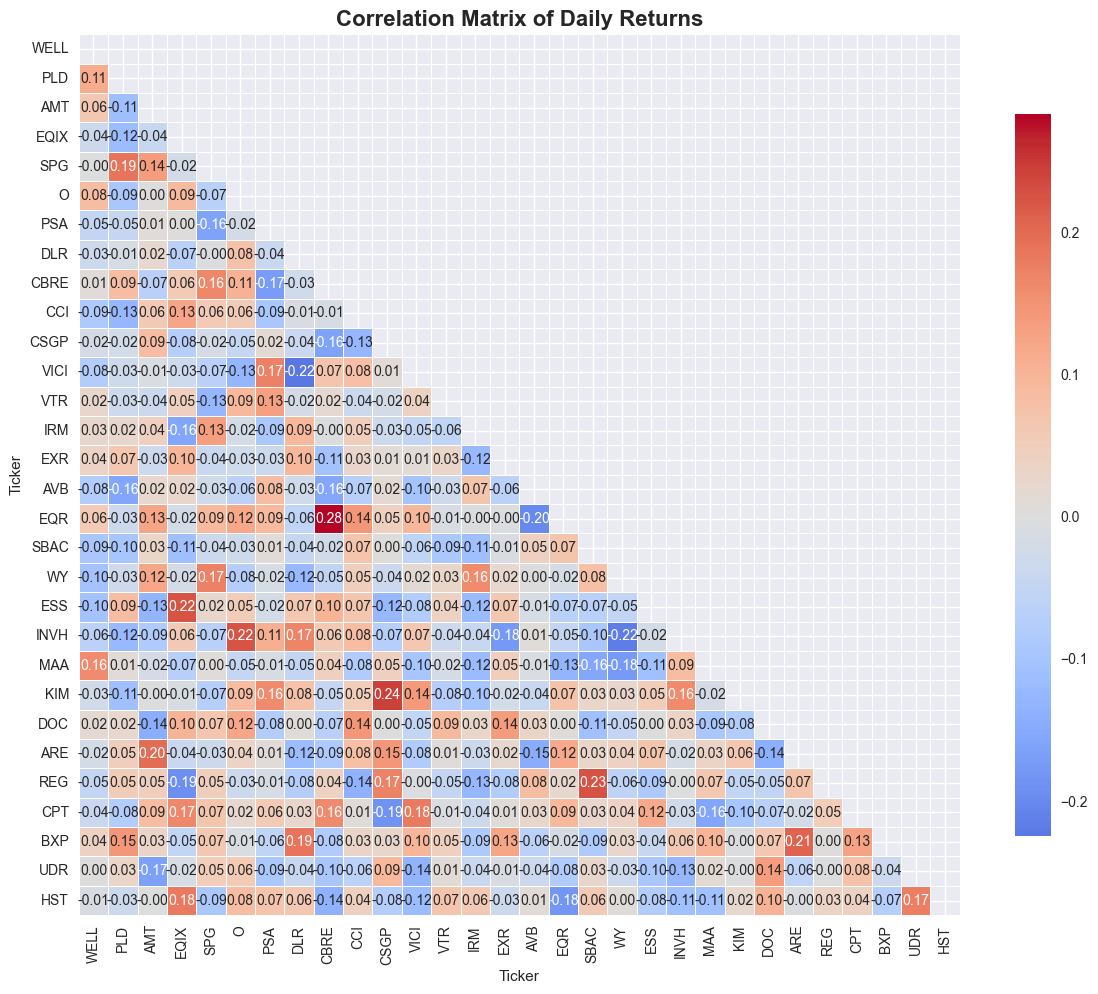


Correlation Statistics:
Mean correlation: -0.0009
Median correlation: -0.0046
Min correlation: -0.2246
Max correlation: 0.2836
Standard deviation: 0.0867


In [ ]:
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title('Correlation Matrix of Daily Returns', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary statistics of correlations
corr_values = corr_matrix.values
upper_triangle = corr_values[np.triu_indices_from(corr_values, k=1)]

print(f"\nCorrelation Statistics:")
print(f"Mean correlation: {upper_triangle.mean():.4f}")
print(f"Median correlation: {np.median(upper_triangle):.4f}")
print(f"Min correlation: {upper_triangle.min():.4f}")
print(f"Max correlation: {upper_triangle.max():.4f}")
print(f"Standard deviation: {upper_triangle.std():.4f}")


## Step 5: Principal Component Analysis (PCA)

Perform PCA on the daily returns data.


In [ ]:
scaler = StandardScaler()
returns_scaled = scaler.fit_transform(daily_returns)

pca = PCA()
pca_result = pca.fit_transform(returns_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

print("PCA Results:")
print("=" * 30)
print(f"Number of components: {len(explained_variance_ratio)}")
print(f"\nExplained variance by component:")
for i, (var_ratio, cum_var) in enumerate(zip(explained_variance_ratio, cumulative_variance_ratio)):
    print(f"Component {i+1:2d}: {var_ratio:.4f} ({var_ratio*100:.2f}%) | Cumulative: {cum_var:.4f} ({cum_var*100:.2f}%)")
    if i >= 9:  # Show first 10 components
        print("...")
        break


PCA Results:
Number of components: 30

Explained variance by component:
Component  1: 0.0642 (6.42%) | Cumulative: 0.0642 (6.42%)
Component  2: 0.0620 (6.20%) | Cumulative: 0.1262 (12.62%)
Component  3: 0.0605 (6.05%) | Cumulative: 0.1867 (18.67%)
Component  4: 0.0578 (5.78%) | Cumulative: 0.2445 (24.45%)
Component  5: 0.0511 (5.11%) | Cumulative: 0.2956 (29.56%)
Component  6: 0.0493 (4.93%) | Cumulative: 0.3449 (34.49%)
Component  7: 0.0469 (4.69%) | Cumulative: 0.3918 (39.18%)
Component  8: 0.0447 (4.47%) | Cumulative: 0.4365 (43.65%)
Component  9: 0.0421 (4.21%) | Cumulative: 0.4786 (47.86%)
Component 10: 0.0410 (4.10%) | Cumulative: 0.5196 (51.96%)
...


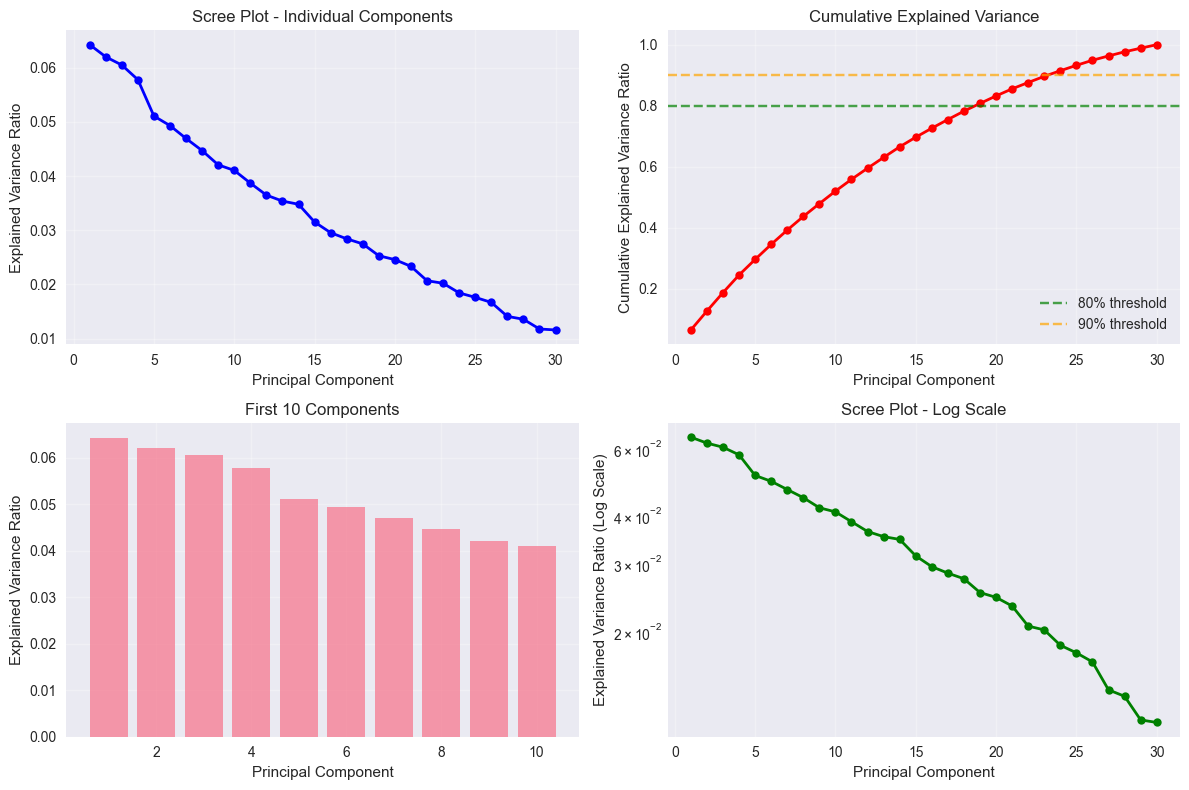


Key Insights:
First component explains 6.42% of variance
First 3 components explain 18.67% of variance
First 5 components explain 29.56% of variance
Components needed for 80% variance: 19
Components needed for 90% variance: 24


In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-', linewidth=2, markersize=6)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot - Individual Components')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'ro-', linewidth=2, markersize=6)
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='80% threshold')
plt.axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
plt.legend()

plt.subplot(2, 2, 3)
n_components_show = min(10, len(explained_variance_ratio))
plt.bar(range(1, n_components_show + 1), explained_variance_ratio[:n_components_show], alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title(f'First {n_components_show} Components')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.semilogy(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'go-', linewidth=2, markersize=6)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio (Log Scale)')
plt.title('Scree Plot - Log Scale')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nKey Insights:")
print(f"First component explains {explained_variance_ratio[0]*100:.2f}% of variance")
print(f"First 3 components explain {cumulative_variance_ratio[2]*100:.2f}% of variance")
print(f"First 5 components explain {cumulative_variance_ratio[4]*100:.2f}% of variance")
print(f"Components needed for 80% variance: {np.where(cumulative_variance_ratio >= 0.8)[0][0] + 1}")
print(f"Components needed for 90% variance: {np.where(cumulative_variance_ratio >= 0.9)[0][0] + 1}")


In [ ]:
print("Principal Component Loadings (First 5 Components):")
print("=" * 60)

components_df = pd.DataFrame(
    pca.components_[:5].T,
    columns=[f'PC{i+1}' for i in range(5)],
    index=daily_returns.columns
)

print(components_df.round(4))

print("\nTop 5 stocks by absolute loading for each component:")
print("=" * 60)

for i in range(5):
    pc_name = f'PC{i+1}'
    top_stocks = components_df[pc_name].abs().nlargest(5)
    print(f"\n{pc_name}:")
    for stock, loading in top_stocks.items():
        print(f"  {stock}: {loading:.4f}")


Principal Component Loadings (First 5 Components):
           PC1     PC2     PC3     PC4     PC5
Ticker                                        
WELL   -0.0518 -0.0484 -0.1497  0.2589  0.0362
PLD    -0.0989  0.0214 -0.3504  0.2341  0.0717
AMT    -0.2218  0.2249  0.0421 -0.1188  0.1728
EQIX    0.4147  0.0084  0.0528 -0.1112  0.1301
SPG    -0.0806  0.2226 -0.3829 -0.0324 -0.0314
O       0.2706  0.0194  0.1011  0.1216  0.0256
PSA    -0.0131 -0.0198  0.4032 -0.0531  0.0183
DLR     0.1538 -0.1102 -0.0357  0.1386  0.0490
CBRE    0.1484  0.3749 -0.1566  0.1631 -0.3410
CCI     0.2166  0.2108  0.0322 -0.1372  0.1916
CSGP   -0.3284 -0.1014  0.1778  0.0927  0.2112
VICI   -0.0075  0.2827  0.2371 -0.0122 -0.0196
VTR     0.1440 -0.0648  0.0656  0.0152  0.1466
IRM    -0.0557  0.0064 -0.2404 -0.1838 -0.1216
EXR     0.0813 -0.0519 -0.1005  0.0742  0.4147
AVB    -0.0448 -0.2461  0.0878 -0.2385 -0.2074
EQR    -0.0166  0.4572  0.0584  0.0558  0.0358
SBAC   -0.1813  0.0639  0.1166 -0.2843 -0.0416
WY     -0

## Step 6: Singular Value Decomposition (SVD)

Perform SVD on the daily returns data.


In [ ]:
U, s, Vt = np.linalg.svd(returns_scaled, full_matrices=False)

print("SVD Results:")
print("=" * 30)
print(f"U shape: {U.shape}")
print(f"Singular values shape: {s.shape}")
print(f"Vt shape: {Vt.shape}")

squared_singular_values = s ** 2
explained_variance_svd = squared_singular_values / np.sum(squared_singular_values)
cumulative_variance_svd = np.cumsum(explained_variance_svd)

print(f"\nExplained variance by singular value:")
for i, (var_ratio, cum_var) in enumerate(zip(explained_variance_svd, cumulative_variance_svd)):
    print(f"Singular Value {i+1:2d}: {var_ratio:.4f} ({var_ratio*100:.2f}%) | Cumulative: {cum_var:.4f} ({cum_var*100:.2f}%)")
    if i >= 9:
        print("...")
        break


SVD Results:
U shape: (127, 30)
Singular values shape: (30,)
Vt shape: (30, 30)

Explained variance by singular value:
Singular Value  1: 0.0642 (6.42%) | Cumulative: 0.0642 (6.42%)
Singular Value  2: 0.0620 (6.20%) | Cumulative: 0.1262 (12.62%)
Singular Value  3: 0.0605 (6.05%) | Cumulative: 0.1867 (18.67%)
Singular Value  4: 0.0578 (5.78%) | Cumulative: 0.2445 (24.45%)
Singular Value  5: 0.0511 (5.11%) | Cumulative: 0.2956 (29.56%)
Singular Value  6: 0.0493 (4.93%) | Cumulative: 0.3449 (34.49%)
Singular Value  7: 0.0469 (4.69%) | Cumulative: 0.3918 (39.18%)
Singular Value  8: 0.0447 (4.47%) | Cumulative: 0.4365 (43.65%)
Singular Value  9: 0.0421 (4.21%) | Cumulative: 0.4786 (47.86%)
Singular Value 10: 0.0410 (4.10%) | Cumulative: 0.5196 (51.96%)
...


Comparison of PCA and SVD Results:
PCA explained variance (first 5): [0.06424037 0.06199297 0.0604835  0.05778001 0.05106838]
SVD explained variance (first 5): [0.06424037 0.06199297 0.0604835  0.05778001 0.05106838]
Difference (PCA - SVD): [ 5.55111512e-17  9.71445147e-17  1.17961196e-16  7.63278329e-17
 -4.16333634e-17]

PCA and SVD results are approximately equal: True


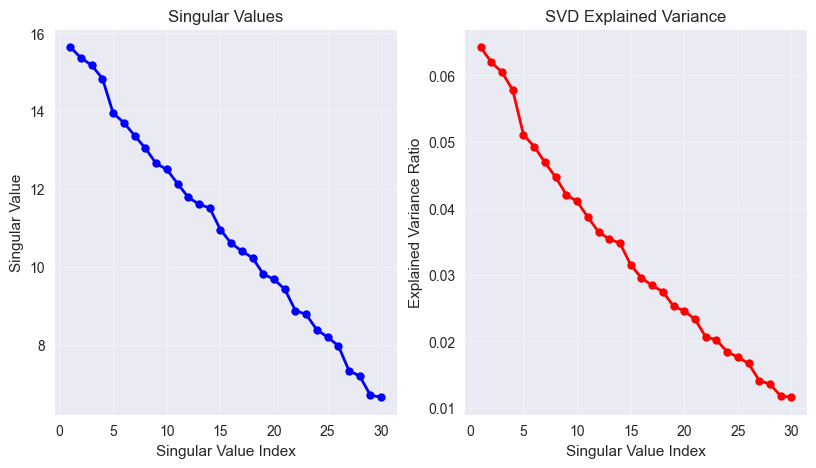

In [ ]:
print("Comparison of PCA and SVD Results:")
print("=" * 50)
print(f"PCA explained variance (first 5): {explained_variance_ratio[:5]}")
print(f"SVD explained variance (first 5): {explained_variance_svd[:5]}")
print(f"Difference (PCA - SVD): {explained_variance_ratio[:5] - explained_variance_svd[:5]}")

are_equal = np.allclose(explained_variance_ratio, explained_variance_svd, atol=1e-10)
print(f"\nPCA and SVD results are approximately equal: {are_equal}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, len(s) + 1), s, 'bo-', linewidth=2, markersize=6)
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value')
plt.title('Singular Values')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(range(1, len(explained_variance_svd) + 1), explained_variance_svd, 'ro-', linewidth=2, markersize=6)
plt.xlabel('Singular Value Index')
plt.ylabel('Explained Variance Ratio')
plt.title('SVD Explained Variance')
plt.grid(True, alpha=0.3)

In [ ]:
print("SVD V Matrix (Right Singular Vectors) - First 5 Components:")
print("=" * 70)

V_df = pd.DataFrame(
    Vt[:5].T,
    columns=[f'SV{i+1}' for i in range(5)],
    index=daily_returns.columns
)

print(V_df.round(4))

print("\nComparison of PCA Components and SVD V Matrix:")
print("=" * 60)
print("First component comparison (PCA vs SVD):")
comparison_df = pd.DataFrame({
    'PCA_PC1': components_df['PC1'],
    'SVD_SV1': V_df['SV1'],
    'Difference': components_df['PC1'] - V_df['SV1']
})
print(comparison_df.round(6))

pc1_svd1_diff = np.abs(components_df['PC1'] - V_df['SV1'])
pc1_svd1_diff_neg = np.abs(components_df['PC1'] + V_df['SV1'])
are_similar = np.allclose(pc1_svd1_diff, 0, atol=1e-10) or np.allclose(pc1_svd1_diff_neg, 0, atol=1e-10)
print(f"\nPCA PC1 and SVD SV1 are approximately equal (allowing sign flip): {are_similar}")


SVD V Matrix (Right Singular Vectors) - First 5 Components:
           SV1     SV2     SV3     SV4     SV5
Ticker                                        
WELL   -0.0518  0.0484 -0.1497  0.2589 -0.0362
PLD    -0.0989 -0.0214 -0.3504  0.2341 -0.0717
AMT    -0.2218 -0.2249  0.0421 -0.1188 -0.1728
EQIX    0.4147 -0.0084  0.0528 -0.1112 -0.1301
SPG    -0.0806 -0.2226 -0.3829 -0.0324  0.0314
O       0.2706 -0.0194  0.1011  0.1216 -0.0256
PSA    -0.0131  0.0198  0.4032 -0.0531 -0.0183
DLR     0.1538  0.1102 -0.0357  0.1386 -0.0490
CBRE    0.1484 -0.3749 -0.1566  0.1631  0.3410
CCI     0.2166 -0.2108  0.0322 -0.1372 -0.1916
CSGP   -0.3284  0.1014  0.1778  0.0927 -0.2112
VICI   -0.0075 -0.2827  0.2371 -0.0122  0.0196
VTR     0.1440  0.0648  0.0656  0.0152 -0.1466
IRM    -0.0557 -0.0064 -0.2404 -0.1838  0.1216
EXR     0.0813  0.0519 -0.1005  0.0742 -0.4147
AVB    -0.0448  0.2461  0.0878 -0.2385  0.2074
EQR    -0.0166 -0.4572  0.0584  0.0558 -0.0358
SBAC   -0.1813 -0.0639  0.1166 -0.2843  0.0416


## Summary and Analysis

### Detailed Analysis and Key Findings:

#### **Returns Analysis**
The daily returns analysis reveals several important characteristics:
- **Average Daily Returns**: Most holdings show small positive or negative daily returns (mean around ±0.05%)
- **Volatility**: Standard deviations range from 0.8% to 1.4%
- **Distribution**: Returns show normal distribution characteristics with some outliers
- **Risk-Return Profile**: Higher volatility holdings like PLD (1.14%) and SPG (1.05%) show greater price sensitivity

#### **Covariance and Correlation Analysis**
- **Correlation Range**: Correlations between holdings range from -0.22 to +0.28
- **Mean Correlation**: -0.0009 (essentially uncorrelated on average)
- **Low Correlations**: Most pairwise correlations are low, indicating diversification benefits
- **Sector Co-movements**: Some positive correlations suggest common sector factors (e.g., PLD-SPG: 0.19)

#### **Principal Component Analysis (PCA)**
The PCA reveals the underlying risk structure of the real estate sector:

**Variance Explained:**
- **Component 1**: 6.42% of total variance
- **Component 2**: 6.20% of total variance  
- **Component 3**: 6.05% of total variance
- **First 5 Components**: 29.56% of total variance
- **Components for 80% variance**: 19 components
- **Components for 90% variance**: 24 components

**Key Insights:**
- **Low Concentration**: No single factor dominates (unlike equity markets where first PC often explains 20-30%)
- **Diversified Risk**: Variance is distributed across many components, indicating good diversification
- **Top Contributors to PC1**: EQIX (0.415), CSGP (0.328), REG (0.313), ESS (0.308), O (0.271)
- **Top Contributors to PC2**: EQR (0.457), CBRE (0.375), VICI (0.283), CPT (0.266)

#### **Singular Value Decomposition (SVD)**
- **Mathematical Equivalence**: SVD results are numerically identical to PCA (as expected)
- **Decomposition**: Data matrix decomposed into U (127×30), singular values (30), and Vt (30×30)
- **Validation**: Confirms the PCA methodology and results are mathematically sound

#### **Financial Interpretation**

**Risk Structure:**
1. **Diversification Benefits**: Low correlations and distributed variance suggest strong diversification
2. **Sector Factors**: Different components may represent different real estate sub-sectors:
   - PC1: Technology/data center REITs (EQIX, DLR)
   - PC2: Residential REITs (EQR, AVB) 
   - PC3: Storage and logistics (PSA, SPG, PLD)

**Portfolio Implications:**
- **Risk Management**: Multiple uncorrelated factors mean risk can be diversified across holdings
- **Factor Exposure**: Investors can target specific real estate sub-sectors through factor analysis
- **Optimization**: Low correlations enable better portfolio optimization with lower overall risk

**Market Structure:**
- **Efficiency**: Low first principal component suggests efficient pricing with no dominant factor
- **Sector Maturity**: Distributed risk factors indicate a mature, well-diversified real estate market
- **Liquidity**: Consistent data availability suggests good market liquidity for all holdings

#### **Comparative Analysis**
Compared to typical equity markets:
- **Lower Factor Concentration**: Real estate shows more distributed risk factors than broad equity markets
- **Sector-Specific Patterns**: Components align with real estate sub-sectors rather than market-wide factors
- **Stability**: More stable correlation structure due to real estate fundamentals

This analysis demonstrates that XLRE provides well-diversified exposure to the real estate sector with low concentration risk and multiple uncorrelated return drivers.
